<img src='https://repository-images.githubusercontent.com/121802384/c355bb80-7d42-11e9-9e0e-4729609f9fbc' alt='WRF-Hydro Logo' width="15%"/>

# Lesson x - Evaluating Model Performance 

## Overview
In this lesson, We will discuss WRF-Hydro model performance evaluation using model outcomes. After model calibration and validation, we have a best parameter set for WRF-Hydro model. Applying the best parameter set to an objectve basin, we will be able to generate various hydrological variables such as streamflow, snow, soil moisture and more. Many error functions are used for model perfomnace evaulation. In particular, we will be focused on the streamflow analysis.
As mentioned in Lesson 3, the WRF-Hydro output files employ standard netCDF4 files, and we use a few Python libraries and commands in this tutorial. 

## Introduction to our Python environment and libraries
As mentioned Lesson 3, we are using Python 3 for all exercises in this tutorial. Please refer to the Lesson 3 for details of python environemnt and libraries.

## Dataset for NetCDF4
In the lesson, the Python command of Dataset is used for WRF-Hydro outputs that are netCDF4 files.

`Dataset('path-to-netcdf-file','r')`: Read a single netCDF file. 

After we read the datasets, we can extract some variables which are included in the netCDF output files. This example indicates the variable of steamflow: 

`my_dataset = Dataset('path-to-netcdf-file','r')`

`streamflow_data = my_dataset.variables['streamflow']`


## Error Criteria
Some error functions are used to evaluate WRF-Hydro model performances. 

| Error Functions | Formula | Best Match Value |
| ------------- | ------------- | ------------- |
| Root Mean Square Error | $$ \text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(OBS_i - SIM_i)^2} $$ | <center> 0 </center> |
| Percent Bias | $$ \text{PBIAS} = \frac{\sum_{i=1}^{n} (OBS_i - \ SIM_i)}{\sum_{i=1}^{n} OBS_i} \times 100 $$ | <center> 0 </center> |
| Nash–Sutcliffe efficiency | $$ \text{NSE} = 1 - \frac{\sum_{i=1}^{n} (OBS_i - \ SIM_i)^2}{\sum_{i=1}^{n} (OBS_i - \bar{OBS})^2} $$ | <center> 1 </center> |
| Kling-Gupta Efficiency | $$ \text{KGE} = 1 - \sqrt{(r - 1)^2 + (\beta - 1)^2 + (\gamma - 1)^2} $$ | <center> 1 </center> |

## Examples
### Plot and Calculate Errors in Streamflow

In this example, we will plot the simulated and observed values using real 2-year WRF-Hydro model outputs, and calculate the errors between them.

**Load WRF-Hydro Output**

In [283]:
path = "/home/docker/wrf-hydro-training/example_case/supplemental/wrf-hydro-output/"
usgsid = 13010065
comid = 23123539

**Load the libraries**

In [284]:
import datetime
import numpy as np
import pandas as pd
import hydroeval as hydro
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from datetime import date, timedelta

**Read netCDF files and Extract Simulations**

In [285]:
begDate = datetime.datetime(2019,1,1)
endDate = datetime.datetime(2021,1,1)
dt = endDate - begDate
nHours = dt.days*24
time1 = np.empty([nHours],np.int32)
data1 = np.empty([nHours],np.float32)
for hour in range(0,nHours):
    dcurrent = begDate + datetime.timedelta(seconds=3600*hour)
    fileIn = path + dcurrent.strftime('%Y%m%d%H') + '00.CHANOBS_DOMAIN1'
    todays = dcurrent.strftime('%Y%m%d%H')
    idTmp = Dataset(fileIn,'r')
    index = np.where(idTmp.variables['feature_id'][:] == comid)[0]
    time1[hour] = int(todays)
    data1[hour] = idTmp.variables['streamflow'][0][index]

timeday = np.arange(np.datetime64("2019-01-01"), np.datetime64("2021-01-01"))
timehour = np.arange(np.datetime64("2019-01-01"), np.datetime64("2021-01-01"), timedelta(hours=1))
base_hour = pd.DataFrame(data1[:])
base_hour['time'] = timehour
base_hour.columns = ['Base_Hours','Time']
base_day = base_hour.set_index('Time').resample('24H').mean()
print (base_day)

            Base_Hours
Time                  
2019-01-01    5.719860
2019-01-02    5.688402
2019-01-03    5.657236
2019-01-04    5.626369
2019-01-05    5.595802
...                ...
2020-12-27    5.850914
2020-12-28    5.824188
2020-12-29    5.797671
2020-12-30    5.771356
2020-12-31    5.745191

[731 rows x 1 columns]


**Read .csv file and Extract Observations**

In [286]:
pathobs = path + str(usgsid) + '.csv'
obsdf = pd.read_csv(pathobs)
print (obsdf)

      site_no   POSIXct quality_flag       obs  threshold  basinType
0    13010065    1/1/19          A e  9.542829  111.56898          0
1    13010065    1/2/19            A  9.712731  111.56898          0
2    13010065    1/3/19            A  9.882633  111.56898          0
3    13010065    1/4/19            A  9.825999  111.56898          0
4    13010065    1/5/19            A  9.797682  111.56898          0
..        ...       ...          ...       ...        ...        ...
726  13010065  12/27/20            A  8.126979  111.56898          0
727  13010065  12/28/20            A  7.872126  111.56898          0
728  13010065  12/29/20            A  8.240247  111.56898          0
729  13010065  12/30/20            A  8.240247  111.56898          0
730  13010065  12/31/20            A  7.928760  111.56898          0

[731 rows x 6 columns]


**Calculate Errors**

In [287]:
SIM=pd.DataFrame(base_day); SIM=SIM.reset_index(drop=True); SIM.columns=['flow']
OBS=pd.DataFrame(obsdf.obs); OBS=OBS.reset_index(drop=True); OBS.columns=['flow']

rmse = np.sqrt(np.mean((OBS-SIM)**2))

aver_bias=np.mean(SIM-OBS)
pv = np.std(OBS)
pbias = 100 * (abs(aver_bias) / pv)

nse = hydro.evaluator(hydro.nse, SIM,OBS)

kge,r,alpha,beta=hydro.evaluator(hydro.kge,SIM,OBS)

print(rmse)

flow    15.03325
dtype: float64


**Plotting Streamflow**

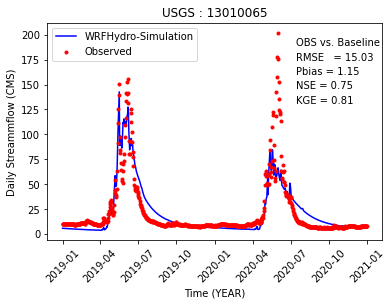

In [288]:
fig = plt.figure()
plt.plot(timeday,base_day,"-b",label="WRFHydro-Simulation")
plt.scatter(timeday,obsdf.obs,marker='.',color='r',zorder=10,label="Observed")
plt.xlabel('Time (YEAR)')
plt.ylabel('Daily Streammflow (CMS)')
plt.legend(loc='upper left')
titlename = 'USGS : ' + str(usgsid)
plt.title(titlename)
plt.xticks(rotation=45);
fig.text(0.7,0.8,'OBS vs. Baseline')
RMSE="RMSE   = {:.2f}".format(rmse.item())
PBIAS="Pbias = {:.2f}".format(pbias.item())
NSE="NSE = {:.2f}".format(nse.item())
KGE="KGE = {:.2f}".format(kge.item())
fig.text(0.7,0.75,str(RMSE))
fig.text(0.7,0.70,str(PBIAS))
fig.text(0.7,0.65,str(NSE))
fig.text(0.7,0.60,str(KGE));